# Storage

In [61]:
# Third-party packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Local imports
from utils import get_data
from utils import tech_order, tech_colors
from utils import get_data_sftp
from datetime import datetime
from pytz import timezone

plt.style.use("style.txt")
pd.options.display.float_format = '{:,.2f}'.format


Bad key legend.labelcolor in file style.txt, line 43 ('legend.labelcolor: black')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution


### Load files

In [62]:
hostname="shasta-db1.ream.ucsd.edu"
username="n7gonzalez"
scenario_name = ["scenario_190", "scenario_191", "scenario_192", "scenario_193", "scenario_194", "scenario_195", "scenario_196", "scenario_197",
                 "scenario_198", "scenario_199"]
savefig = False
folder_to_save_results="results/"

In [63]:
fname = "storage_capacity.csv"
storage_capacity = get_data_sftp(hostname, username, scenario_name, fname)
storage_capacity = storage_capacity[storage_capacity['period']==2050]
storage_capacity

,generation_project,period,load_zone,OnlinePowerCapacityMW,OnlineEnergyCapacityMWh,scenario
67,1191209720,2050,AZ_APS_E,0.00,0.00,scenario_190
71,1191209721,2050,AZ_APS_N,0.00,0.00,scenario_190
75,1191209722,2050,AZ_APS_SW,"3,177.60","18,684.00",scenario_190
79,1191209723,2050,AZ_NM_N,0.00,0.00,scenario_190
83,1191209724,2050,AZ_NW,"2,911.10","17,117.00",scenario_190
...,...,...,...,...,...,...
247,1191209765,2050,WA_W,0.00,0.00,scenario_199
251,1191209766,2050,WY_NE,0.00,0.00,scenario_199
255,1191209767,2050,WY_NW,0.00,0.00,scenario_199
259,1191209768,2050,WY_SE,"2,122.70","9,521.20",scenario_199


In [64]:
storage_capacity.insert(5,"Storage_duration_h",storage_capacity["OnlineEnergyCapacityMWh"]/storage_capacity["OnlinePowerCapacityMW"])
storage_capacity['Storage_duration_h']=storage_capacity['Storage_duration_h'].fillna(0)
storage_capacity.insert(4,"OnlineEnergyCapacityGWh",storage_capacity['OnlineEnergyCapacityMWh']/1000)

#storage_capacity=storage_capacity[storage_capacity.Storage_duration_h != 0]
storage_capacity = storage_capacity[storage_capacity['period']==2050]
storage_capacity

,generation_project,period,load_zone,OnlinePowerCapacityMW,OnlineEnergyCapacityGWh,OnlineEnergyCapacityMWh,Storage_duration_h,scenario
67,1191209720,2050,AZ_APS_E,0.00,0.00,0.00,0.00,scenario_190
71,1191209721,2050,AZ_APS_N,0.00,0.00,0.00,0.00,scenario_190
75,1191209722,2050,AZ_APS_SW,"3,177.60",18.68,"18,684.00",5.88,scenario_190
79,1191209723,2050,AZ_NM_N,0.00,0.00,0.00,0.00,scenario_190
83,1191209724,2050,AZ_NW,"2,911.10",17.12,"17,117.00",5.88,scenario_190
...,...,...,...,...,...,...,...,...
247,1191209765,2050,WA_W,0.00,0.00,0.00,0.00,scenario_199
251,1191209766,2050,WY_NE,0.00,0.00,0.00,0.00,scenario_199
255,1191209767,2050,WY_NW,0.00,0.00,0.00,0.00,scenario_199
259,1191209768,2050,WY_SE,"2,122.70",9.52,"9,521.20",4.49,scenario_199


### Analysis in WECC

In [65]:
duration_wecc=storage_capacity.pivot_table(
    index="load_zone", columns="scenario", values="Storage_duration_h", aggfunc=np.sum
)

duration_wecc = duration_wecc.reindex(columns=scenario_name)

,count,mean,std,min,25%,50%,75%,max
scenario,,,,,,,,
scenario_190,50.00,2.80,2.94,0.00,0.00,0.00,5.88,5.88
scenario_191,50.00,2.68,2.94,0.00,0.00,0.00,5.88,5.88
scenario_192,50.00,2.71,2.89,0.00,0.00,0.00,5.88,5.88
scenario_193,50.00,2.62,2.89,0.00,0.00,0.00,5.88,5.88
scenario_194,50.00,2.49,2.87,0.00,0.00,0.00,5.88,5.88
scenario_195,50.00,2.97,2.92,0.00,0.00,3.79,5.88,5.88
scenario_196,50.00,2.77,2.92,0.00,0.00,0.00,5.88,5.88
scenario_197,50.00,2.77,2.92,0.00,0.00,0.00,5.88,5.88
scenario_198,50.00,2.86,2.91,0.00,0.00,2.02,5.88,5.88


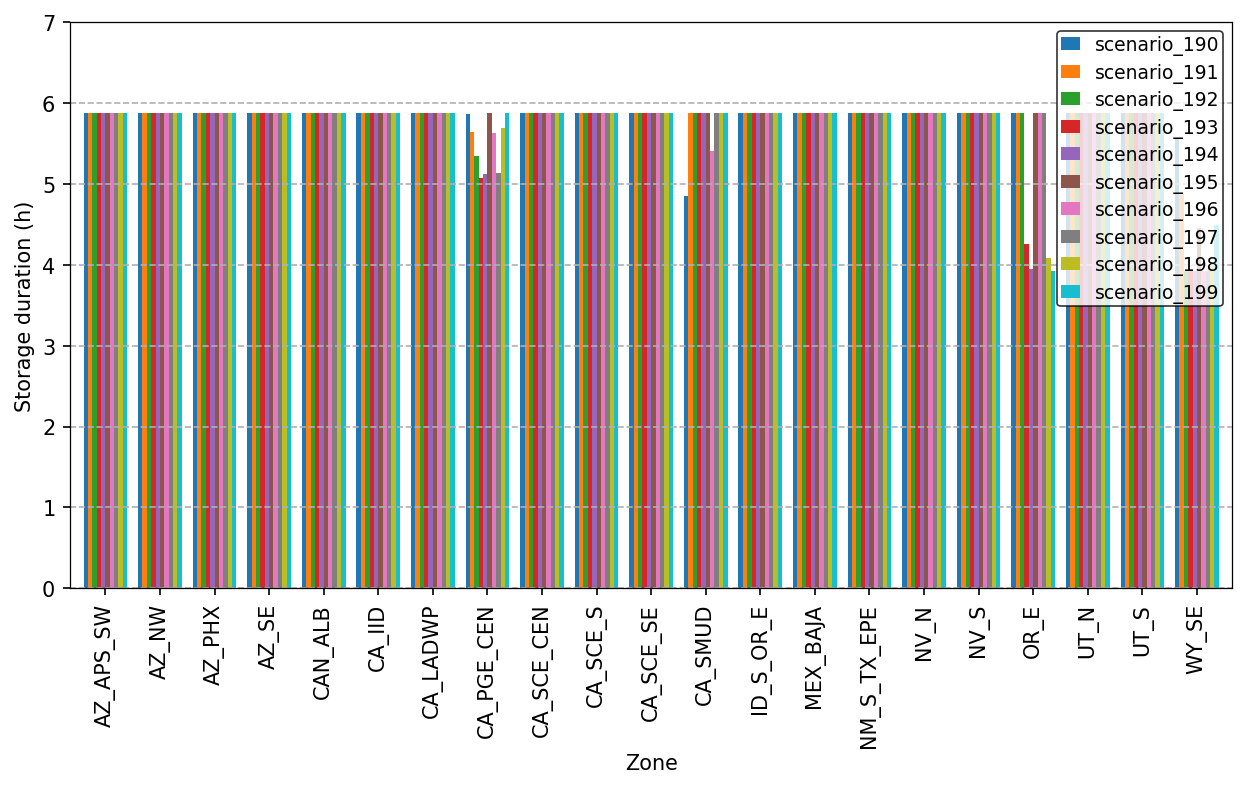

In [66]:
fig = plt.figure(figsize=(10,  5), dpi=150)

fig.patch.set_facecolor('white')

ax = fig.add_subplot(1, 1, 1)

# Exclude transmission lines with 0 additions
data = (duration_wecc[duration_wecc != 0]).dropna()

# Main figure
data.plot.bar(ax=ax, lw=0, width=0.8)
plt.xlabel("Zone")
plt.ylabel("Storage duration (h)")

ax.grid(axis='y', linestyle='dashed')

ax.legend(
   # handles[::-1],
   # labels[::-1],
   # bbox_to_anchor=(1, 1),
    loc="best",
    fontsize=9,
    handlelength=1,
    frameon=True,
    edgecolor="black",
    facecolor="white",
)

ax.patch.set_facecolor('white')

plt.savefig(folder_to_save_results+"Storage duration in WECC.png", transparent=False)


duration_wecc.describe().T.to_latex(folder_to_save_results+"Storage duration in WECC.tex",index=True,
                                  float_format='%.2f', columns=["mean", "std", "25%", "50%","75%", "max"],
                                  caption="Statistics of storage duration (h) in WECC")

duration_wecc.describe().T


In [67]:
storagecap_wecc=storage_capacity.pivot_table(
    index="load_zone", columns="scenario", values="OnlineEnergyCapacityGWh", aggfunc=np.sum
)
storagecap_wecc = storagecap_wecc.reindex(columns=scenario_name)

,count,mean,std,min,25%,50%,75%,max
scenario,,,,,,,,
scenario_190,50.00,13.17,26.98,0.00,0.00,0.00,15.98,145.02
scenario_191,50.00,13.01,26.89,0.00,0.00,0.00,15.64,143.92
scenario_192,50.00,12.68,26.23,0.00,0.00,0.00,15.57,137.01
scenario_193,50.00,12.44,25.38,0.00,0.00,0.00,13.12,129.01
scenario_194,50.00,12.35,25.24,0.00,0.00,0.00,13.31,127.73
scenario_195,50.00,13.25,27.31,0.00,0.00,0.55,13.60,144.94
scenario_196,50.00,12.89,26.95,0.00,0.00,0.00,14.00,141.44
scenario_197,50.00,12.47,25.74,0.00,0.00,0.00,13.47,133.43
scenario_198,50.00,12.24,25.16,0.00,0.00,0.20,12.83,129.46


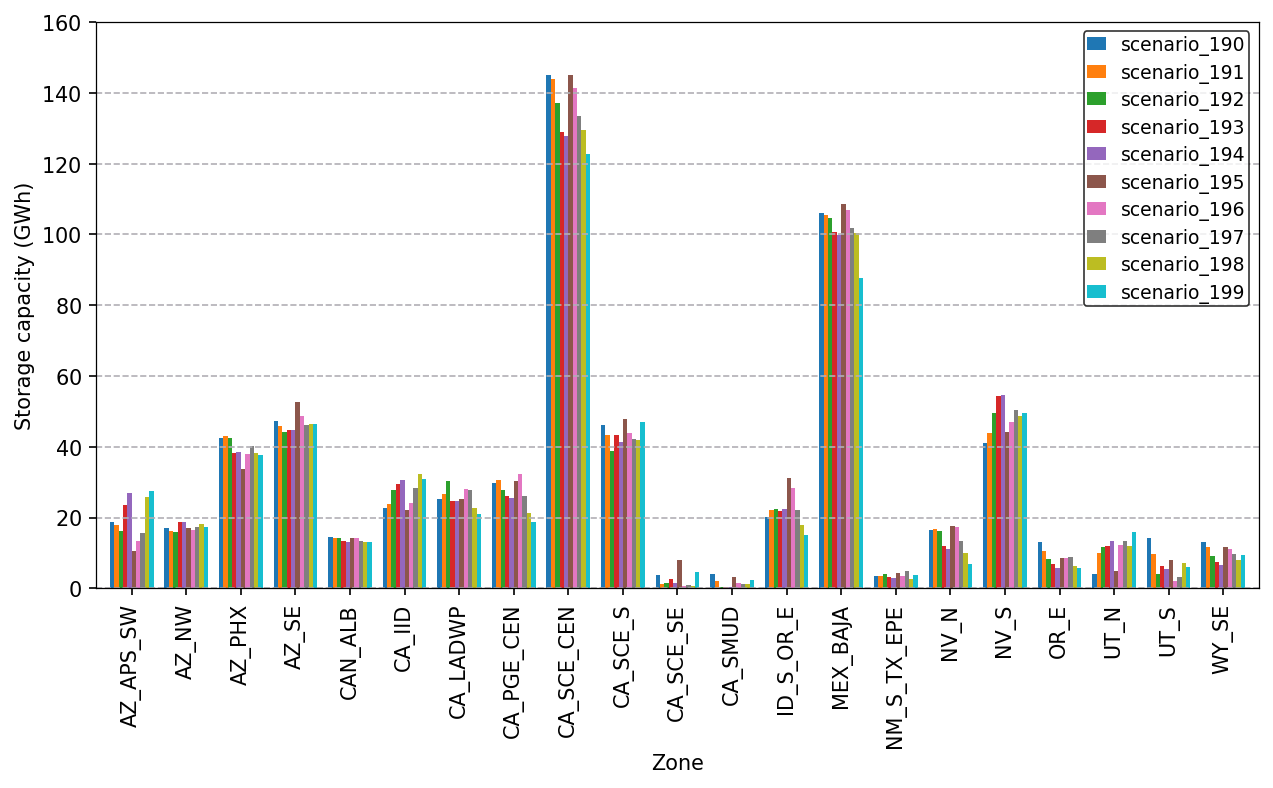

In [68]:
fig = plt.figure(figsize=(10,  5), dpi=150)

fig.patch.set_facecolor('white')

ax = fig.add_subplot(1, 1, 1)

# Exclude transmission lines with 0 additions
data = (storagecap_wecc[storagecap_wecc != 0]).dropna()

# Main figure
data.plot.bar(ax=ax, lw=0, width=0.8)
plt.xlabel("Zone")
plt.ylabel("Storage capacity (GWh)")

ax.grid(axis='y', linestyle='dashed')

ax.legend(
   # handles[::-1],
   # labels[::-1],
   # bbox_to_anchor=(1, 1),
    loc="best",
    fontsize=9,
    handlelength=1,
    frameon=True,
    edgecolor="black",
    facecolor="white",
)

ax.patch.set_facecolor('white')


plt.savefig(folder_to_save_results+"Storage capacity in WECC.png", transparent=False)

storagecap_wecc.describe().T.to_latex(folder_to_save_results+"Storage Capacity in WECC.tex",index=True,
                                  float_format='%.2f', columns=["mean", "std", "25%", "50%","75%", "max"],
                                  caption="Statistics of storage capacity (GWh) in WECC")

storagecap_wecc.describe().T


### Analysis in California

In [69]:
#Filter to California
storage_capacity_ca=storage_capacity[storage_capacity.load_zone.str.startswith('CA_')]

In [70]:
duration_ca=storage_capacity_ca.pivot_table(
    index="load_zone", columns="scenario", values="Storage_duration_h", aggfunc=np.sum
)
duration_ca= duration_ca.reindex(columns=scenario_name)

,count,mean,std,min,25%,50%,75%,max
scenario,,,,,,,,
scenario_190,12.00,4.32,2.62,0.00,3.64,5.88,5.88,5.88
scenario_191,12.00,3.90,2.88,0.00,0.00,5.88,5.88,5.88
scenario_192,12.00,3.87,2.87,0.00,0.00,5.88,5.88,5.88
scenario_193,12.00,3.85,2.85,0.00,0.00,5.88,5.88,5.88
scenario_194,12.00,3.86,2.86,0.00,0.00,5.88,5.88,5.88
scenario_195,12.00,4.41,2.66,0.00,4.41,5.88,5.88,5.88
scenario_196,12.00,3.86,2.85,0.00,0.00,5.76,5.88,5.88
scenario_197,12.00,3.86,2.86,0.00,0.00,5.88,5.88,5.88
scenario_198,12.00,3.90,2.88,0.00,0.00,5.88,5.88,5.88


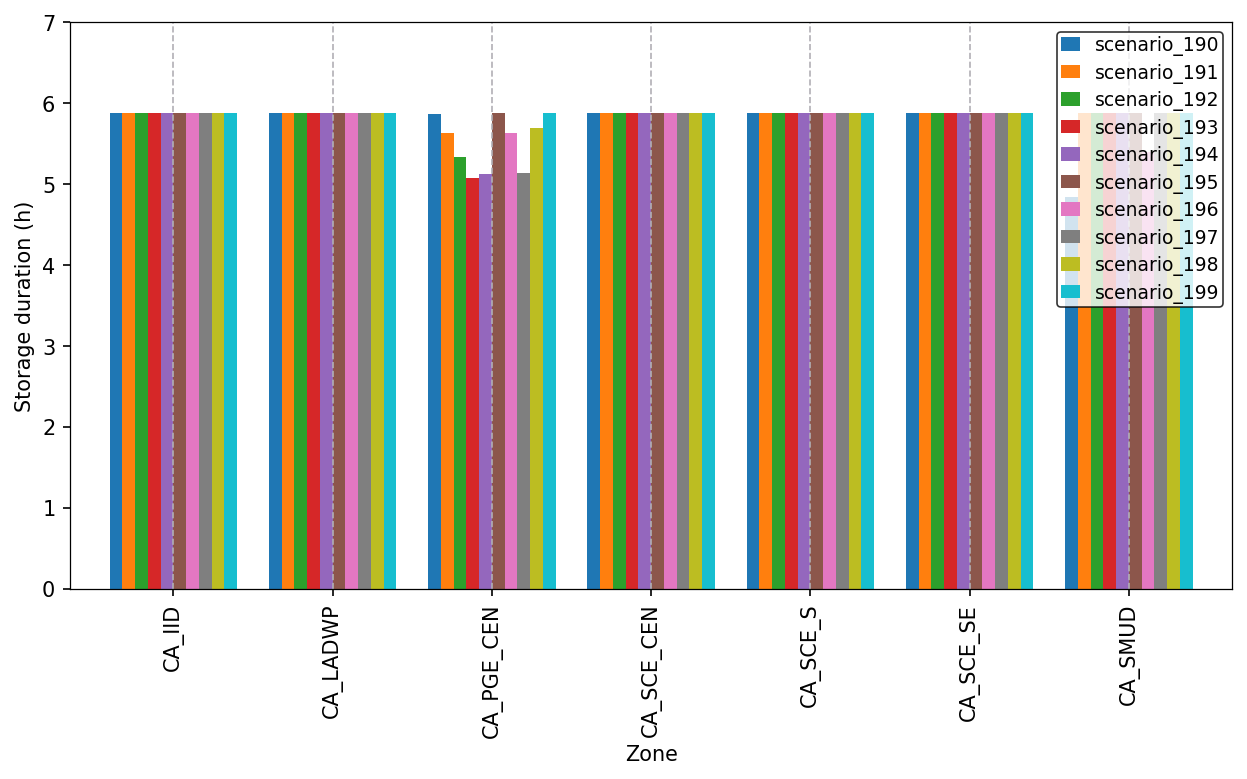

In [71]:
fig = plt.figure(figsize=(10, 5), dpi=150)

fig.patch.set_facecolor('white')

ax = fig.add_subplot(1, 1, 1)

# Exclude transmission lines with 0 additions
data = (duration_ca[duration_ca != 0]).dropna()

# Main figure
data.plot.bar(ax=ax, lw=0, width=0.8)
plt.ylabel("Storage duration (h)")
plt.xlabel("Zone")


ax.grid(axis='x', linestyle='dashed')

ax.legend(
   # handles[::-1],
   # labels[::-1],
   # bbox_to_anchor=(1, 1),
    loc="best",
    fontsize=9,
    handlelength=1,
    frameon=True,
    edgecolor="black",
    facecolor="white",
)

ax.patch.set_facecolor('white')

plt.savefig(folder_to_save_results+"Storage duration in California.png", transparent=False)


duration_ca.describe().T.to_latex(folder_to_save_results+"Storage duration in California.tex",index=True,
                                  float_format='%.2f', columns=["mean", "std", "25%", "50%","75%", "max"],
                                  caption="Statistics of storage duration (h) in California")

duration_ca.describe().T

In [72]:
storagecap_ca=storage_capacity_ca.pivot_table(
    index="load_zone", columns="scenario", values="OnlineEnergyCapacityGWh", aggfunc=np.sum
)
storagecap_ca= storagecap_ca.reindex(columns=scenario_name)

,count,mean,std,min,25%,50%,75%,max
scenario,,,,,,,,
scenario_190,12.00,23.44,41.19,0.00,0.58,3.97,26.40,145.02
scenario_191,12.00,22.96,41.03,0.00,0.00,2.94,27.68,143.92
scenario_192,12.00,22.23,39.12,0.00,0.00,2.23,28.48,137.01
scenario_193,12.00,21.47,37.14,0.00,0.00,2.18,26.99,129.01
scenario_194,12.00,21.13,36.75,0.00,0.00,1.73,26.75,127.73
scenario_195,12.00,24.28,40.89,0.00,2.31,7.13,26.59,144.94
scenario_196,12.00,22.95,40.49,0.00,0.00,2.47,29.10,141.44
scenario_197,12.00,21.83,38.29,0.00,0.00,1.61,27.96,133.43
scenario_198,12.00,20.95,37.25,0.00,0.00,1.46,25.20,129.46


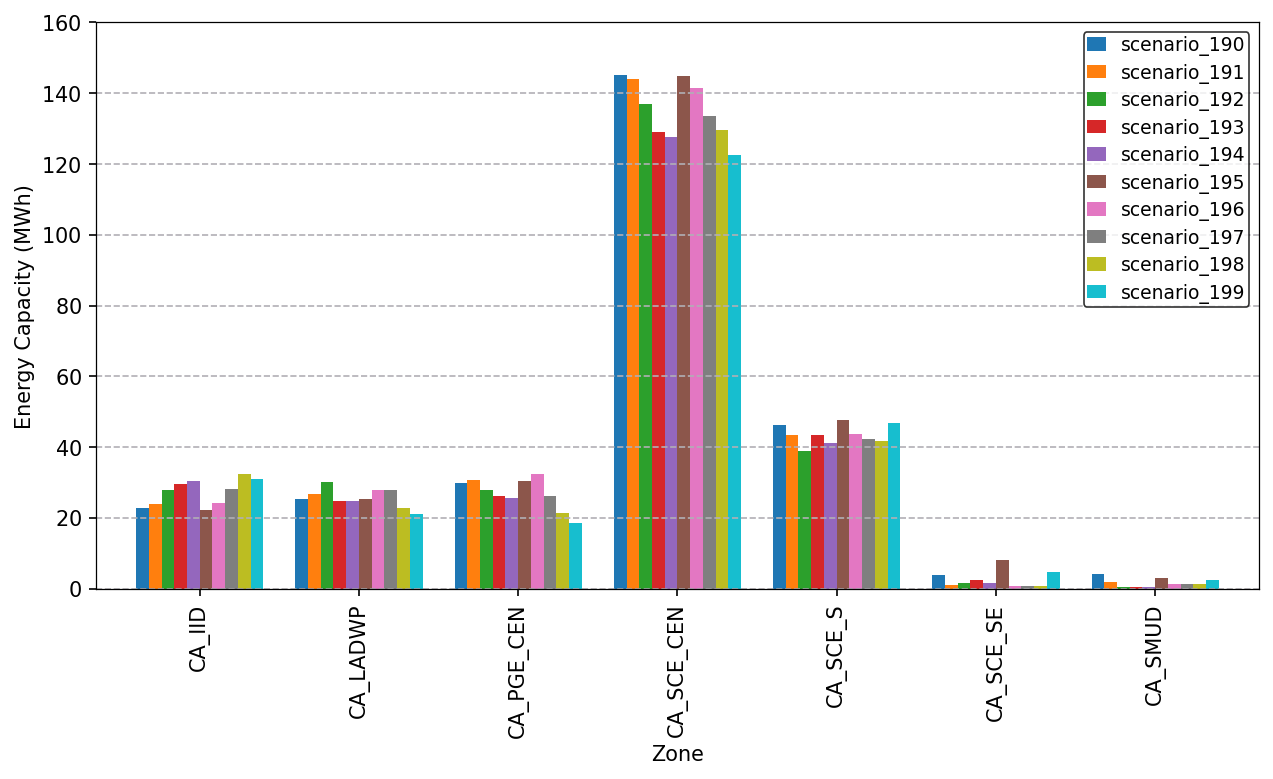

In [73]:
fig = plt.figure(figsize=(10, 5), dpi=150)

fig.patch.set_facecolor('white')

ax = fig.add_subplot(1, 1, 1)

# Exclude transmission lines with 0 additions
data = (storagecap_ca[storagecap_ca != 0]).dropna()

# Main figure
data.plot.bar(ax=ax, lw=0, width=0.8)
plt.ylabel("Energy Capacity (MWh)")
plt.xlabel("Zone")


ax.grid(axis='y', linestyle='dashed')

ax.legend(
   # handles[::-1],
   # labels[::-1],
   # bbox_to_anchor=(1, 1),
    loc="best",
    fontsize=9,
    handlelength=1,
    frameon=True,
    edgecolor="black",
    facecolor="white",
)

ax.patch.set_facecolor('white')

plt.savefig(folder_to_save_results+"Storage capacity in California.png", transparent=False)


storagecap_ca.describe().T.to_latex(folder_to_save_results+"Storage capacity (GWh) in California.tex",index=True,
                                  float_format='%.2f', columns=["mean", "std", "25%", "50%","75%", "max"],
                                  caption="Statistics of storage capacity (GWh) in California")

storagecap_ca.describe().T

### Analysis out of California

In [74]:
zones_ca=storage_capacity[storage_capacity["scenario"].isin(["base"])]
zones_ca=list(zones_ca[zones_ca.load_zone.str.startswith('CA_')].load_zone)
storage_capacity_outca=storage_capacity[~storage_capacity["load_zone"].isin(zones_ca)]
storage_capacity_outca

,generation_project,period,load_zone,OnlinePowerCapacityMW,OnlineEnergyCapacityGWh,OnlineEnergyCapacityMWh,Storage_duration_h,scenario
67,1191209720,2050,AZ_APS_E,0.00,0.00,0.00,0.00,scenario_190
71,1191209721,2050,AZ_APS_N,0.00,0.00,0.00,0.00,scenario_190
75,1191209722,2050,AZ_APS_SW,"3,177.60",18.68,"18,684.00",5.88,scenario_190
79,1191209723,2050,AZ_NM_N,0.00,0.00,0.00,0.00,scenario_190
83,1191209724,2050,AZ_NW,"2,911.10",17.12,"17,117.00",5.88,scenario_190
...,...,...,...,...,...,...,...,...
247,1191209765,2050,WA_W,0.00,0.00,0.00,0.00,scenario_199
251,1191209766,2050,WY_NE,0.00,0.00,0.00,0.00,scenario_199
255,1191209767,2050,WY_NW,0.00,0.00,0.00,0.00,scenario_199
259,1191209768,2050,WY_SE,"2,122.70",9.52,"9,521.20",4.49,scenario_199


In [75]:
duration_outca=storage_capacity_outca.pivot_table(
    index="load_zone", columns="scenario", values="Storage_duration_h", aggfunc=np.sum
)
duration_outca= duration_outca.reindex(columns=scenario_name)

,count,mean,std,min,25%,50%,75%,max
scenario,,,,,,,,
scenario_190,50.00,2.80,2.94,0.00,0.00,0.00,5.88,5.88
scenario_191,50.00,2.68,2.94,0.00,0.00,0.00,5.88,5.88
scenario_192,50.00,2.71,2.89,0.00,0.00,0.00,5.88,5.88
scenario_193,50.00,2.62,2.89,0.00,0.00,0.00,5.88,5.88
scenario_194,50.00,2.49,2.87,0.00,0.00,0.00,5.88,5.88
scenario_195,50.00,2.97,2.92,0.00,0.00,3.79,5.88,5.88
scenario_196,50.00,2.77,2.92,0.00,0.00,0.00,5.88,5.88
scenario_197,50.00,2.77,2.92,0.00,0.00,0.00,5.88,5.88
scenario_198,50.00,2.86,2.91,0.00,0.00,2.02,5.88,5.88


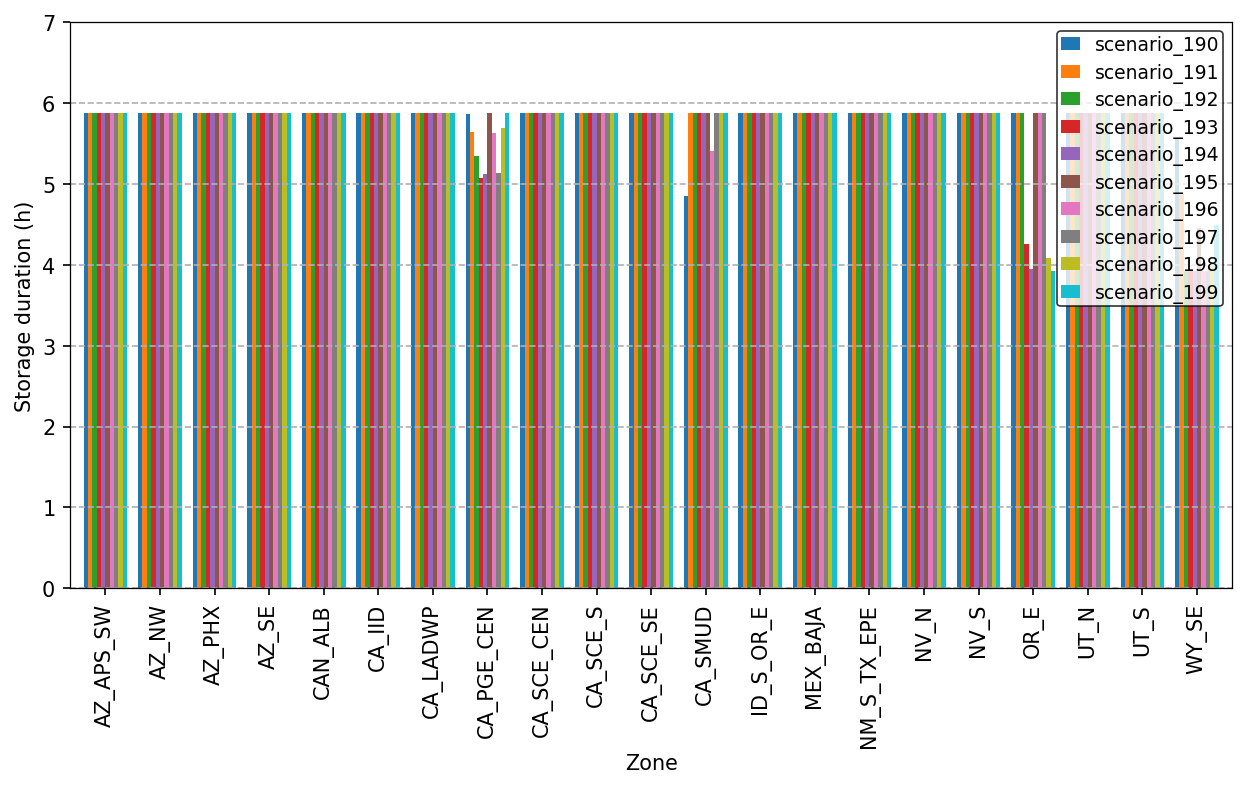

In [76]:
fig = plt.figure(figsize=(10, 5), dpi=150)

fig.patch.set_facecolor('white')

ax = fig.add_subplot(1, 1, 1)

# Exclude transmission lines with 0 additions
data = (duration_outca[duration_outca != 0]).dropna()

# Main figure
data.plot.bar(ax=ax, lw=0, width=0.8)
plt.ylabel("Storage duration (h)")
plt.xlabel("Zone")

ax.grid(axis='y', linestyle='dashed')

ax.legend(
   # handles[::-1],
   # labels[::-1],
   # bbox_to_anchor=(1, 1),
    loc="best",
    fontsize=9,
    handlelength=1,
    frameon=True,
    edgecolor="black",
    facecolor="white",
)

ax.patch.set_facecolor('white')

plt.savefig(folder_to_save_results+"Storage duration out of California.png", transparent=False)


duration_outca.describe().T.to_latex(folder_to_save_results+"Storage duration out of California.tex",index=True,
                                  float_format='%.2f', columns=["mean", "std", "25%", "50%","75%", "max"],
                                  caption="Statistics of storage duration (h) out of California")

duration_outca.describe().T

In [77]:
storagecap_outca=storage_capacity_outca.pivot_table(
    index="load_zone", columns="scenario", values="OnlineEnergyCapacityGWh", aggfunc=np.sum
)
storagecap_outca= storagecap_outca.reindex(columns=scenario_name)

,count,mean,std,min,25%,50%,75%,max
scenario,,,,,,,,
scenario_190,50.00,13.17,26.98,0.00,0.00,0.00,15.98,145.02
scenario_191,50.00,13.01,26.89,0.00,0.00,0.00,15.64,143.92
scenario_192,50.00,12.68,26.23,0.00,0.00,0.00,15.57,137.01
scenario_193,50.00,12.44,25.38,0.00,0.00,0.00,13.12,129.01
scenario_194,50.00,12.35,25.24,0.00,0.00,0.00,13.31,127.73
scenario_195,50.00,13.25,27.31,0.00,0.00,0.55,13.60,144.94
scenario_196,50.00,12.89,26.95,0.00,0.00,0.00,14.00,141.44
scenario_197,50.00,12.47,25.74,0.00,0.00,0.00,13.47,133.43
scenario_198,50.00,12.24,25.16,0.00,0.00,0.20,12.83,129.46


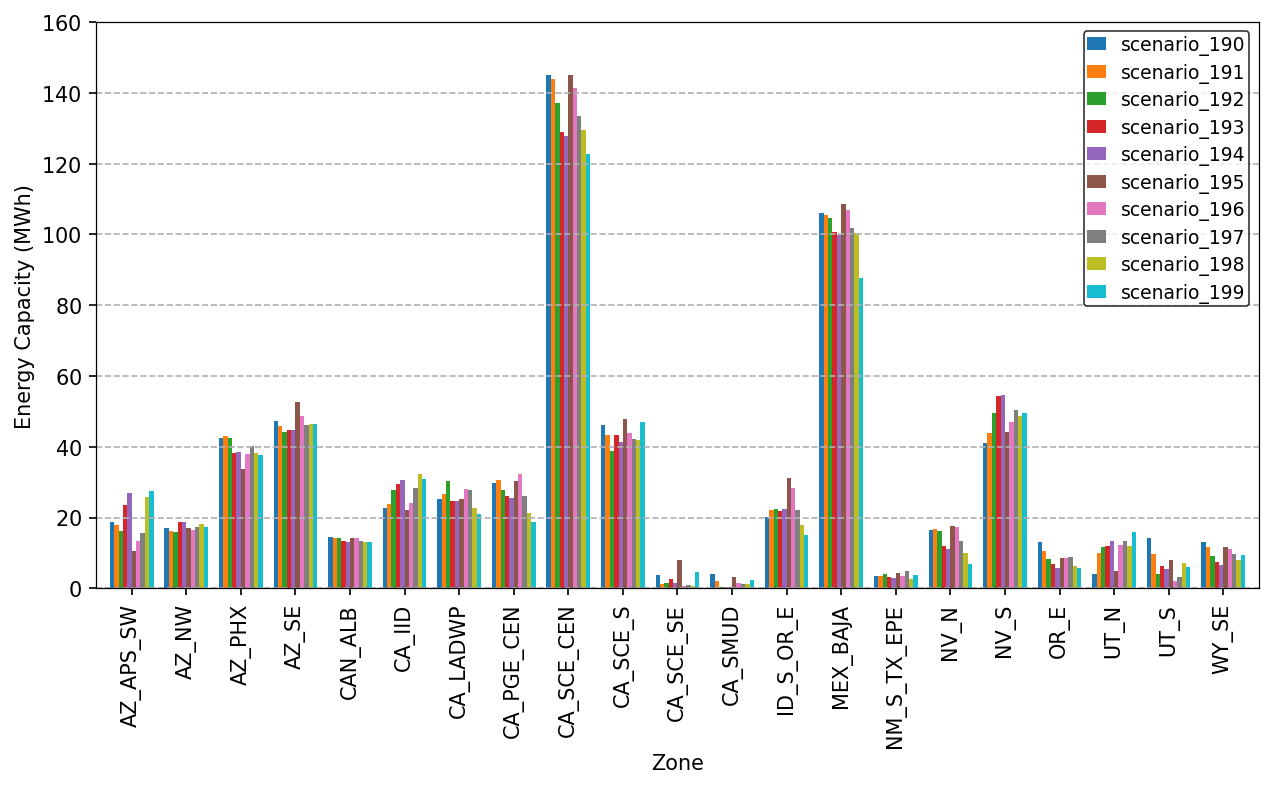

In [78]:
fig = plt.figure(figsize=(10, 5), dpi=150)

fig.patch.set_facecolor('white')

ax = fig.add_subplot(1, 1, 1)

# Exclude transmission lines with 0 additions
data = (storagecap_outca[storagecap_outca != 0]).dropna()

# Main figure
data.plot.bar(ax=ax, lw=0, width=0.8)
plt.ylabel("Energy Capacity (MWh)")
plt.xlabel("Zone")

ax.grid(axis='y', linestyle='dashed')

ax.legend(
   # handles[::-1],
   # labels[::-1],
   # bbox_to_anchor=(1, 1),
    loc="best",
    fontsize=9,
    handlelength=1,
    frameon=True,
    edgecolor="black",
    facecolor="white",
)

ax.patch.set_facecolor('white')

plt.savefig(folder_to_save_results+"Storage capacity out of California.png", transparent=False)


storagecap_outca.describe().T.to_latex(folder_to_save_results+"Storage capacity out of California.tex",index=True,
                                  float_format='%.2f', columns=["mean", "std", "25%", "50%","75%", "max"],
                                  caption="Statistics of storage capacity (GWh) out of California")

storagecap_outca.describe().T